In [6]:
# Imports
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import find_peaks, peak_widths
import scipy.stats as stats
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from PIL import Image


In [95]:
#create a dictionary to store all arrays and convert radians into degrees

# Define the folder path containing .mat files
folder_path ='D:\\Phoebe-data\\Horizontal\\Data'

# Get a list of all .mat files in the directory
file_names = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

# Initialize dictionaries to store the extracted and converted data
fitted_osi_angle_deg_mod = {}

# Loop through each file and process
for idx, file_name in enumerate(file_names, start=1):
    file_path = os.path.join(folder_path, file_name)
    
    # Load the .mat file
    data = loadmat(file_path)
    
    # Access the variable
    variable = data['DEFAULTS_POST_GROUP']
    
    # Extract the specific field
    fitted_osi_angle_deg = np.rad2deg(variable['fitted_osi_angle'][0, 0]) % 180
    
    # Store in the dictionary
    fitted_osi_angle_deg_mod[idx] = fitted_osi_angle_deg
    
# Initialize a new dictionary for the modified arrays
modified_fitted_osi_angle_deg_mod = {}

# Process each array in the dictionary
for idx, angles in fitted_osi_angle_deg_mod.items():
    # Filter values between 0 and 25
    mask = (angles >= 0) & (angles <= 25)
    
    # Modify the values
    modified_angles = np.where(mask, angles + 180, angles)
    
    # Store the modified array in the new dictionary
    modified_fitted_osi_angle_deg_mod[idx] = modified_angles


#Have a look how the shift works

# Choose an example index (e.g., array 1)
example_idx = 3# Adjust this index as needed

# Retrieve the original and modified arrays
original_angles = fitted_osi_angle_deg_mod[example_idx]
modified_angles = modified_fitted_osi_angle_deg_mod[example_idx]

# Create subplots: 1 row, 2 columns for side-by-side comparison
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for the original array
axs[0].hist(original_angles, bins=180, color='blue', alpha=0.7)
axs[0].set_title(f"Original Array (Idx {example_idx})")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("Frequency")
axs[0].set_xlim([0, 180])  # Ensure consistent x-axis limits


# Plot histogram for the modified array
axs[1].hist(modified_angles, bins=180, color='green', alpha=0.7)
axs[1].set_title(f"Modified Array (Idx {example_idx})")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("Frequency")
axs[1].set_xlim([25, 205])  # Ensure consistent x-axis limits

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

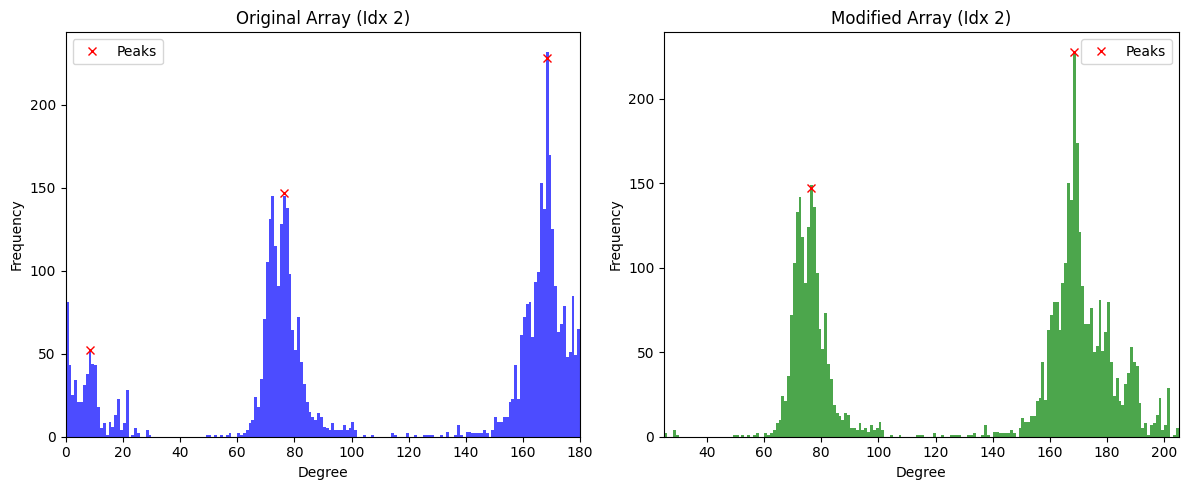

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Choose an example index (e.g., array 1)
example_idx = 2# Adjust this index as needed

# Retrieve the original and modified arrays
original_angles = fitted_osi_angle_deg_mod[example_idx]
modified_angles = modified_fitted_osi_angle_deg_mod[example_idx]

# Create subplots: 1 row, 2 columns for side-by-side comparison
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for the original array
counts_orig, bins_orig = np.histogram(original_angles, bins=180, range=(0, 180))
axs[0].hist(original_angles, bins=180, color='blue', alpha=0.7)
axs[0].set_title(f"Original Array (Idx {example_idx})")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("Frequency")
axs[0].set_xlim([0, 180])  # Ensure consistent x-axis limits

# Calculate bin centers for the original histogram
bin_centers_orig = (bins_orig[:-1] + bins_orig[1:]) / 2

# Find peaks in the original histogram with a minimum distance of 50
peaks_orig, _ = find_peaks(counts_orig, distance=50)
peak_bins_orig = bin_centers_orig[peaks_orig]

# Mark peaks on the original histogram
axs[0].plot(peak_bins_orig, counts_orig[peaks_orig], "x", color='red', label='Peaks')
axs[0].legend()

# Plot histogram for the modified array
counts_mod, bins_mod = np.histogram(modified_angles, bins=180, range=(25, 205))
axs[1].hist(modified_angles, bins=180, color='green', alpha=0.7)
axs[1].set_title(f"Modified Array (Idx {example_idx})")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("Frequency")
axs[1].set_xlim([25, 205])  # Ensure consistent x-axis limits

# Calculate bin centers for the modified histogram
bin_centers_mod = (bins_mod[:-1] + bins_mod[1:]) / 2

# Find peaks in the modified histogram with a minimum distance of 50
peaks_mod, _ = find_peaks(counts_mod, distance=50)
peak_bins_mod = bin_centers_mod[peaks_mod]

# Mark peaks on the modified histogram
axs[1].plot(peak_bins_mod, counts_mod[peaks_mod], "x", color='red', label='Peaks')
axs[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

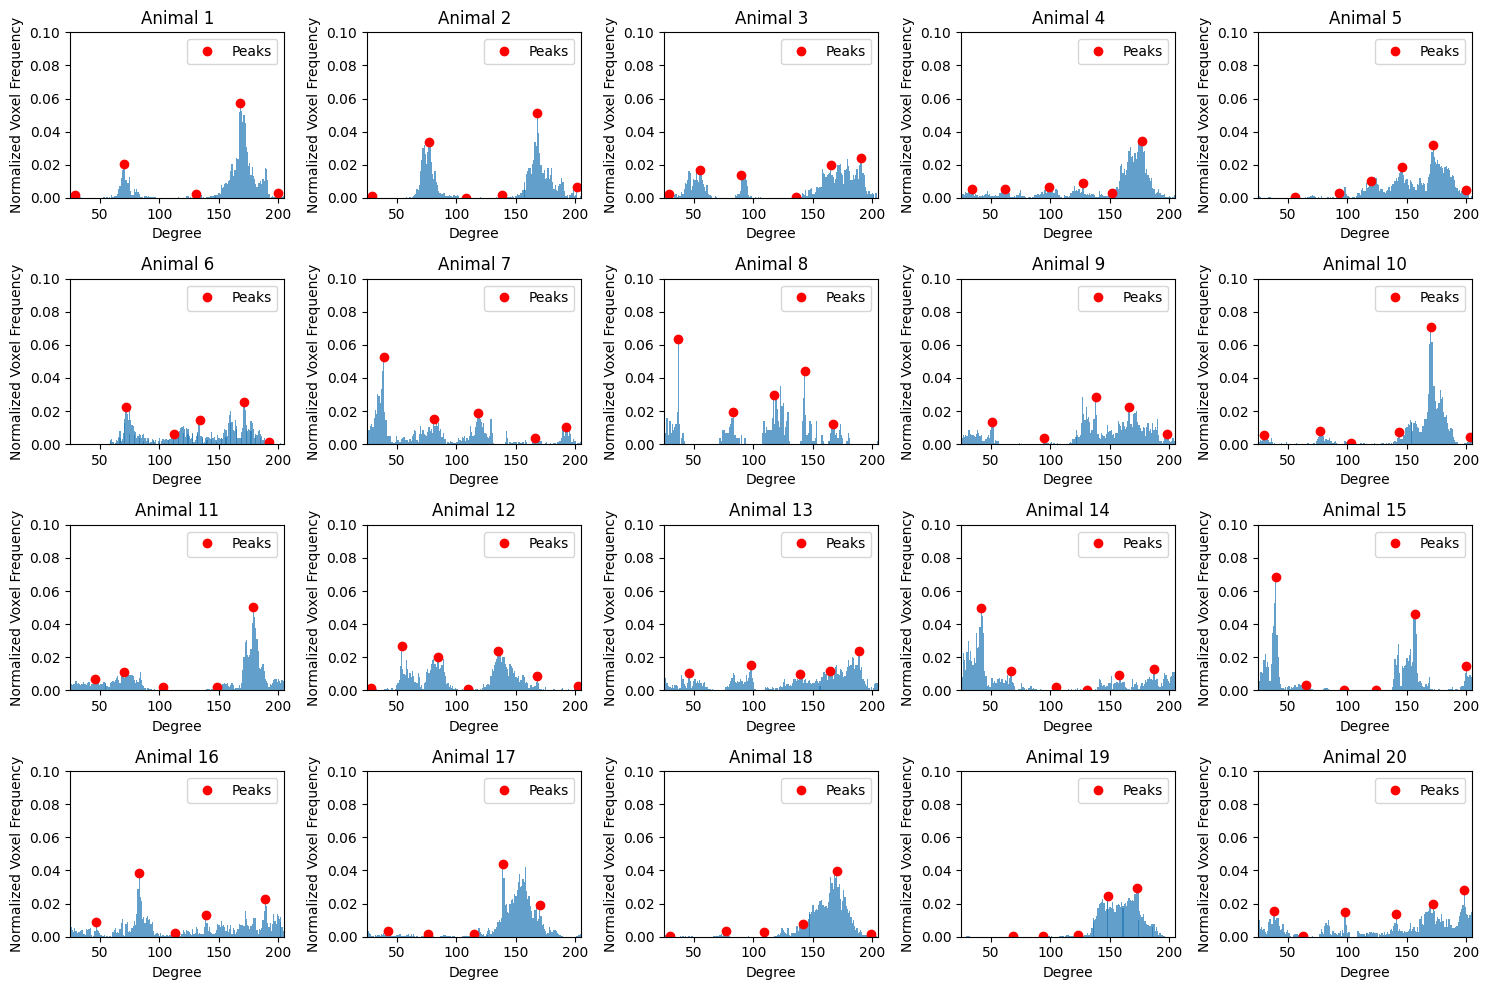

Plot saved to: D:\Phoebe-data\Horizontal\Data\histogram_grid_shifted.png
Normalized peaks data saved to: D:\Phoebe-data\Horizontal\Data\normalized_peaks_data.xlsx
Raw histogram for array 1:
     Frequency  Degree
0            3      27
1            3      28
2            7      29
3            1      30
4            0      31
..         ...     ...
175         10     200
176          4     201
177          4     202
178          1     203
179          3     204

[180 rows x 2 columns]


Normalized histogram for array 1:
     Normalized Frequency  Degree
0                0.000892    27.0
1                0.000892    28.0
2                0.002081    29.0
3                0.000297    30.0
4                0.000000    31.0
..                    ...     ...
175              0.002973   200.0
176              0.001189   201.0
177              0.001189   202.0
178              0.000297   203.0
179              0.000892   204.0

[180 rows x 2 columns]


Peak Data for All Arrays:
     Array Ind

In [97]:
#convert arrays shape into histogram like (column 1: degree; column 2: number of bins); 
#normalise the peaks by dividing each peak by the sum of all voxels; peaks are calculate with distance = 30
#find peaks and store into separate dictionary 

# Create a dictionary for histograms and normalized histograms
histogram_arrays = {}
normalized_histogram_arrays = {}

# List to store peak data
peak_data_list = []

# Set the number of rows and columns for the grid (4x5)
rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten the axes array for easier access

# Loop through the datasets and calculate histograms and peaks
for idx, (data, ax) in enumerate(zip(modified_fitted_osi_angle_deg_mod.values(), axes), start=1):
    
    # Create histogram with 180 bins
    hist, bin_edges = np.histogram(data, bins=180)
    
    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Round values
    hist_rounded = np.round(hist).astype(int)
    bin_centers_rounded = np.round(bin_centers).astype(int)

    # Combine into a structured format (Frequency, Degree)
    histogram_data = np.vstack((hist_rounded, bin_centers_rounded)).T
    df_histogram = pd.DataFrame(histogram_data, columns=['Frequency', 'Degree'])

    # Store the DataFrame for the raw histogram in the dictionary
    histogram_arrays[idx] = df_histogram

    # Normalize by dividing each frequency by the total sum of frequencies
    total_frequency = np.sum(hist_rounded)
    if total_frequency > 0:
        normalized_hist = hist_rounded / total_frequency
    else:
        normalized_hist = hist_rounded

    # Combine normalized frequencies with the bin centers
    normalized_histogram_data = np.vstack((normalized_hist, bin_centers_rounded)).T
    df_normalized_histogram = pd.DataFrame(normalized_histogram_data, columns=['Normalized Frequency', 'Degree'])

    # Store the DataFrame for the normalized histogram in a new dictionary
    normalized_histogram_arrays[idx] = df_normalized_histogram

    # Plot the histogram in the grid
    ax.bar(bin_centers_rounded, normalized_hist, width=1, alpha=0.7)
    ax.set_title(f"Animal {idx}")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Normalized Voxel Frequency")
    ax.set_xlim([25, 205])  # Set x-axis limits for consistency
    ax.set_ylim([0, 0.1])  # Adjust y-axis limits for consistency across plots

    # Find peaks in the normalized histogram data
    peaks, properties = find_peaks(normalized_hist, distance=25, height=0)  # height=0 ensures all peaks are considered
    peak_widths_result = peak_widths(normalized_hist, peaks, rel_height=0.5)

    # Extract peak data (heights, indices, widths) and store it in a list
    for i, peak in enumerate(peaks):
        peak_height = properties['peak_heights'][i]
        peak_index = bin_centers_rounded[peak]  # degree at the peak
        peak_width = peak_widths_result[0][i]  # width of the peak

        peak_data_list.append({
            'Array Index': idx,
            'Peak Value': peak_height,
            'Peak Degree (Index)': peak_index,
            'Peak Width': peak_width
        })

    # Plot peaks on the histogram
    ax.plot(bin_centers_rounded[peaks], normalized_hist[peaks], 'ro', label="Peaks")  # Red dots for peaks
    ax.legend()

# Hide any unused subplots in the grid
for ax in axes[len(modified_fitted_osi_angle_deg_mod):]:
    ax.axis('off')

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Define the folder where the image will be saved
output_directory = folder_path  # Replace with your desired directory path
os.makedirs(output_directory, exist_ok=True)  # Create directory if it doesn't exist
output_image_path = os.path.join(output_directory, 'histogram_grid_shifted.png')

# Save the figure as a PNG file
plt.savefig(output_image_path)

# Show the plot
plt.show()

# Confirmation message
print(f"Plot saved to: {output_image_path}")

# Convert the peak data list into a DataFrame
peak_data_df_normalised = pd.DataFrame(peak_data_list)

# Save the DataFrame to an Excel file
output_file = os.path.join(output_directory, 'normalized_peaks_data.xlsx')
peak_data_df_normalised.to_excel(output_file, index=False)

# Confirmation message
print(f"Normalized peaks data saved to: {output_file}")

# Print the raw and normalized histogram for one array (for example, array with index 1)
example_idx = 1  # Change this index to select a different array

print(f"Raw histogram for array {example_idx}:")
print(histogram_arrays[example_idx])
print("\n")

print(f"Normalized histogram for array {example_idx}:")
print(normalized_histogram_arrays[example_idx])
print("\n")

# Print the DataFrame containing peak information
print("Peak Data for All Arrays:")
print(peak_data_df_normalised)



In [98]:
#HORIZONTAL PEAK RANGE RAW AND EDITED

#Horizontal Peak Range
# Define the range for peak index values, around 80
min_peak_index_h = 50
max_peak_index_h = 100

# Filter peaks_df to include only rows where 'Peak Index' is within the range
filtered_peaks_df_h_normalised_noedit = peak_data_df_normalised[(peak_data_df_normalised['Peak Degree (Index)'] >= min_peak_index_h) & (peak_data_df_normalised['Peak Degree (Index)'] <= max_peak_index_h)]

# Print or save the filtered DataFrame
print(filtered_peaks_df_h_normalised_noedit)

# Ensure the directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the file name for the CSV
csv_file_name = 'horizontal_peaks_normalised_noedit.csv'

# Combine directory path and file name
csv_file_path = os.path.join(output_directory, csv_file_name)

# Save the DataFrame to the CSV file
filtered_peaks_df_h_normalised_noedit.to_csv(csv_file_path, index=False)

# Confirmation message
print(f"Data saved to: {csv_file_path}")


#EDITED
# Filter peaks_df to include only rows where 'Peak Degree (Index)' is within the range
filtered_peaks_df_h_normalised = peak_data_df_normalised[
    (peak_data_df_normalised['Peak Degree (Index)'] >= min_peak_index_h) & 
    (peak_data_df_normalised['Peak Degree (Index)'] <= max_peak_index_h)
]

# Group by 'Array Index' and pick the row with the largest 'Peak Value' for each group
filtered_peaks_df_h_normalised = filtered_peaks_df_h_normalised.loc[filtered_peaks_df_h_normalised.groupby('Array Index')['Peak Value'].idxmax()]

# Determine the range of array indices
existing_indices = filtered_peaks_df_h_normalised['Array Index'].unique()
all_indices = np.arange(existing_indices.min(), existing_indices.max() + 1)

# Create a DataFrame to hold the missing indices with the specified value
missing_indices = [index for index in all_indices if index not in existing_indices]

# Create new rows for the missing indices with a Peak Value of 0.000001
new_rows = pd.DataFrame({
    'Array Index': missing_indices,
    'Peak Value': [0.000001] * len(missing_indices),
    'Peak Degree (Index)': [np.nan] * len(missing_indices),  # Fill with NaN or appropriate value
    'Peak Width': [np.nan] * len(missing_indices)  # Fill with NaN or appropriate value
})

# Check if index 1 or 20 is missing and add it if necessary
if 1 not in existing_indices:
    new_rows = pd.concat([new_rows, pd.DataFrame({
        'Array Index': [1],
        'Peak Value': [0.000001],
        'Peak Degree (Index)': [np.nan],
        'Peak Width': [np.nan]
    })], ignore_index=True)

if 20 not in existing_indices:
    new_rows = pd.concat([new_rows, pd.DataFrame({
        'Array Index': [20],
        'Peak Value': [0.000001],
        'Peak Degree (Index)': [np.nan],
        'Peak Width': [np.nan]
    })], ignore_index=True)
    
# Append the new rows to the filtered DataFrame
filtered_peaks_df_h_normalised = pd.concat([filtered_peaks_df_h_normalised, new_rows], ignore_index=True)

# Sort the DataFrame by 'Array Index'
filtered_peaks_df_h_normalised.sort_values(by='Array Index', inplace=True)

# Print the filtered DataFrame with added missing rows
print(filtered_peaks_df_h_normalised)

# Ensure the directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the file name for the CSV
csv_file_name = 'horizontal_peaks_normalised.csv'

# Combine directory path and file name
csv_file_path = os.path.join(output_directory, csv_file_name)

# Save the DataFrame to the CSV file
filtered_peaks_df_h_normalised.to_csv(csv_file_path, index=False)

# Confirmation message
print(f"Data saved to: {csv_file_path}")

     Array Index  Peak Value  Peak Degree (Index)  Peak Width
1              1    0.020809                   70    4.666667
6              2    0.033596                   77    9.601173
12             3    0.016931                   55    8.750000
13             3    0.013757                   90    5.813131
18             4    0.005258                   62    6.833333
19             4    0.006572                   99    5.666667
23             5    0.000843                   56    2.250000
24             5    0.003092                   93    0.937500
29             6    0.022491                   72    4.642857
35             7    0.015207                   81    5.875000
40             8    0.019366                   83    3.937500
44             9    0.013668                   51    2.490942
45             9    0.003527                   95    1.571429
50            10    0.007796                   77    4.884615
56            11    0.011234                   70   11.378882
61      

In [99]:

#Vertical Peak Range
# Define the range for peak index values
#min_peak_index_v = 160
#max_peak_index_v = 195

# Filter peaks_df to include only rows where 'Peak Index' is within the range
#filtered_peaks_df_v_normalised = peak_data_df_normalised[(peak_data_df_normalised['Peak Degree (Index)'] >= min_peak_index_v) & (peak_data_df_normalised['Peak Degree (Index)'] <= max_peak_index_v)]

# Print or save the filtered DataFrame
#print(filtered_peaks_df_v_normalised)

# Optionally save the filtered DataFrame to a CSV file
#filtered_peaks_df_v_normalised.to_csv('/Users/jacqui/Downloads/01_Group_VPS_mat_per_fish_4to5/Vertical_4to5/vertical_peaks_normalised.csv', index=False)

In [100]:
#Vertical Peak Range
# Define the range for peak index values
min_peak_index_v = 155
max_peak_index_v = 205

# Filter peaks_df to include only rows where 'Peak Index' is within the range
filtered_peaks_df_v_normalised_noedit = peak_data_df_normalised[
    (peak_data_df_normalised['Peak Degree (Index)'] >= min_peak_index_v) & 
    (peak_data_df_normalised['Peak Degree (Index)'] <= max_peak_index_v)
]

# Print or save the filtered DataFrame
print(filtered_peaks_df_v_normalised_noedit)

# Ensure the directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the file name for the CSV
csv_file_name = 'vertical_peaks_normalised_noedit.csv'

# Combine directory path and file name
csv_file_path = os.path.join(output_directory, csv_file_name)

# Save the DataFrame to the CSV file
filtered_peaks_df_v_normalised_noedit.to_csv(csv_file_path, index=False)

# Confirmation message
print(f"Data saved to: {csv_file_path}")


# EDITED
# Filter peaks_df to include only rows where 'Peak Degree (Index)' is within the range
filtered_peaks_df_v_normalised = peak_data_df_normalised[
    (peak_data_df_normalised['Peak Degree (Index)'] >= min_peak_index_v) & 
    (peak_data_df_normalised['Peak Degree (Index)'] <= max_peak_index_v)
]

# Group by 'Array Index' and pick the row with the largest 'Peak Value' for each group
filtered_peaks_df_v_normalised = filtered_peaks_df_v_normalised.loc[
    filtered_peaks_df_v_normalised.groupby('Array Index')['Peak Value'].idxmax()
]

# Determine the range of array indices
existing_indices = filtered_peaks_df_v_normalised['Array Index'].unique()
all_indices = np.arange(existing_indices.min(), existing_indices.max() + 1)

# Create a DataFrame to hold the missing indices with the specified value
missing_indices = [index for index in all_indices if index not in existing_indices]

# Create new rows for the missing indices with a Peak Value of 0.000001
new_rows = pd.DataFrame({
    'Array Index': missing_indices,
    'Peak Value': [0.000001] * len(missing_indices),
    'Peak Degree (Index)': [np.nan] * len(missing_indices),  # Fill with NaN or appropriate value
    'Peak Width': [np.nan] * len(missing_indices)  # Fill with NaN or appropriate value
})

# Check if index 1 or 20 is missing and add it if necessary
if 1 not in existing_indices:
    new_rows = pd.concat([new_rows, pd.DataFrame({
        'Array Index': [1],
        'Peak Value': [0.000001],
        'Peak Degree (Index)': [np.nan],
        'Peak Width': [np.nan]
    })], ignore_index=True)

if 20 not in existing_indices:
    new_rows = pd.concat([new_rows, pd.DataFrame({
        'Array Index': [20],
        'Peak Value': [0.000001],
        'Peak Degree (Index)': [np.nan],
        'Peak Width': [np.nan]
    })], ignore_index=True)

# Append the new rows to the filtered DataFrame
filtered_peaks_df_v_normalised = pd.concat([filtered_peaks_df_v_normalised, new_rows], ignore_index=True)

# Sort the DataFrame by 'Array Index'
filtered_peaks_df_v_normalised.sort_values(by='Array Index', inplace=True)

# Print the filtered DataFrame with added missing rows
print(filtered_peaks_df_v_normalised)

# Ensure the directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the file name for the CSV
csv_file_name = 'vertical_peaks_normalised.csv'

# Combine directory path and file name
csv_file_path = os.path.join(output_directory, csv_file_name)

# Save the DataFrame to the CSV file
filtered_peaks_df_v_normalised.to_csv(csv_file_path, index=False)

# Confirmation message
print(f"Data saved to: {csv_file_path}")

     Array Index  Peak Value  Peak Degree (Index)  Peak Width
3              1    0.057372                  168    7.499527
4              1    0.002973                  200    1.500000
9              2    0.051409                  168    4.984707
10             2    0.006539                  201    1.119122
15             3    0.020106                  165    2.375000
16             3    0.024339                  190    5.168269
22             4    0.034505                  177   15.743750
27             5    0.031759                  172   11.466403
28             5    0.005059                  200    1.509091
32             6    0.025375                  171    2.481481
33             6    0.001153                  192    0.750000
37             7    0.003671                  166    6.375000
38             7    0.010488                  192    3.000000
43             8    0.012324                  167    4.041667
47             9    0.022487                  166    2.331522
48      

In [101]:
 
#Get the data from excel files if you had to modify to make sure there is data for 20 lines, choose peaks

# Define the file path to the CSV file
#csv_file_path_horizontal = '/Users/jacqui/Downloads/01_Group_VPS_mat_per_fish_4to5/Vertical_4to5/horizontal_peaks_normalised.csv'
#csv_file_path_vertical = '/Users/jacqui/Downloads/01_Group_VPS_mat_per_fish_4to5/Vertical_4to5/vertical_peaks_normalised.csv'

# Read the CSV file into a pandas DataFrame
#filtered_peaks_df_h_normalised = pd.read_csv(csv_file_path_horizontal)
#filtered_peaks_df_v_normalised = pd.read_csv(csv_file_path_vertical)

# Print the DataFrame (optional)
#print(filtered_peaks_df_h_normalised)
#print(filtered_peaks_df_v_normalised)



In [102]:
# Getting a list of vertical indeces
# Extract the specific column from each DataFrame
column1 = filtered_peaks_df_h_normalised['Peak Value'].to_numpy()
column2 = filtered_peaks_df_v_normalised['Peak Value'].to_numpy()

# Perform element-wise division
result_v = column2 / (column2 + column1)

# Convert the result back to a DataFrame if needed
result_v_df = pd.DataFrame(result_v, columns=['Vertical Index Normalised'])

# Print or use the resulting DataFrame
print(result_v_df)

# Optionally save the filtered DataFrame to a CSV file
#result_v_df.to_csv('/Users/jacqui/Downloads/01_Group_VPS_mat_per_fish_4to5/Vertical_4to5/vertical_index_normalised.csv', index=False)

# Ensure the directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the file name for the CSV
index_csv_file_name = 'vertical_index_normalised.csv'

# Combine directory path and file name
index_csv_file_path = os.path.join(output_directory, index_csv_file_name)

# Save the DataFrame to the CSV file
result_v_df.to_csv(index_csv_file_path, index=False)

# Confirmation message
print(f"Data saved to: {index_csv_file_path}")

# Convert each number in the array into its log base 2
log_array_v = (np.log2((result_v_df)+0.5)) #add 0.5 so you can nulify the 0.5 index which happens if V peak = H peak

# Print the result
print(log_array_v)
type(log_array_v)

# Define the file name for the CSV
logindex_csv_file_name = 'vertical_index_normalised_log.csv'

# Combine directory path and file name
logindex_csv_file_path = os.path.join(output_directory, logindex_csv_file_name)

# Save the DataFrame to the CSV file
log_array_v.to_csv(logindex_csv_file_path, index=False)

# Confirmation message
print(f"Data saved to: {logindex_csv_file_path}")


    Vertical Index Normalised
0                    0.733840
1                    0.604775
2                    0.589744
3                    0.840000
4                    0.911290
5                    0.530120
6                    0.408163
7                    0.388889
8                    0.621951
9                    0.900552
10                   0.818182
11                   0.239130
12                   0.606383
13                   0.519231
14                   0.932927
15                   0.372549
16                   0.931818
17                   0.914286
18                   0.978723
19                   0.652778
Data saved to: D:\Phoebe-data\Horizontal\Data\vertical_index_normalised.csv
    Vertical Index Normalised
0                    0.303156
1                    0.143752
2                    0.123989
3                    0.422233
4                    0.497015
5                    0.042813
6                   -0.138976
7                   -0.169925
8                    0.1

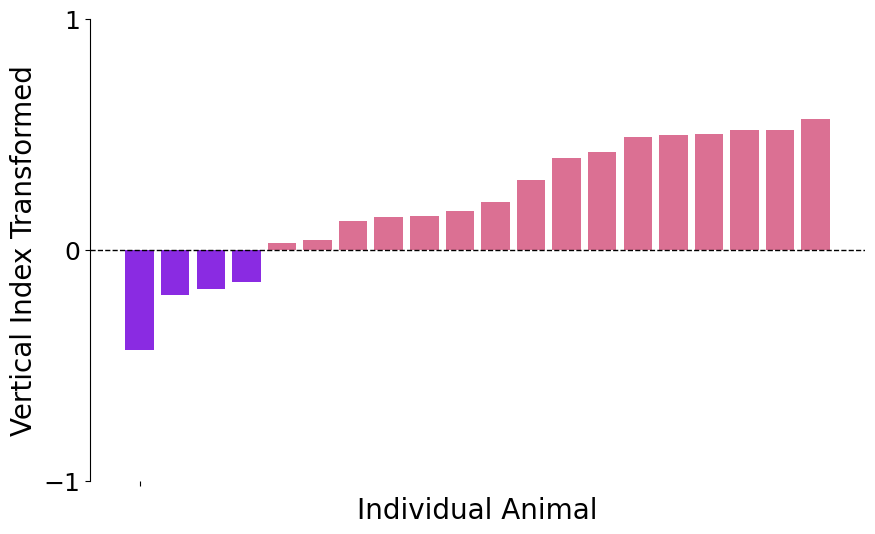

Plot saved to: D:\Phoebe-data\Control\Data\data_in_relation_to_zero_aligned_with_indices.png


In [103]:
# Assuming log_array_v is already defined and populated with the necessary data
# Convert the 'Vertical Index Normalised' column to floats
log_array_v['Vertical Index Normalised'] = log_array_v['Vertical Index Normalised'].astype(float)

# Sort the data in ascending order while retaining the original indices
sorted_data = log_array_v['Vertical Index Normalised'].sort_values()

# Extract sorted values and their corresponding original indices
sorted_values = sorted_data.values  # Sorted values for y-axis
sorted_indices = sorted_data.index + 1  # Original indices for x-axis (add 1 to make indices start from 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0
plt.bar(range(1, len(sorted_values) + 1), sorted_values, 
        color=['palevioletred' if i >= 0 else 'blueviolet' for i in sorted_values], width=0.8)

# Add labels and title
plt.ylabel('Vertical Index Transformed', fontsize=20)
plt.ylim([-1, 1])
plt.yticks(np.arange(-1, 2, 1), fontsize = 18)  # Set y-ticks at -1, 0, and 1

plt.xlabel('Individual Animal', fontsize=20)
plt.xticks([1], labels= (''))  # Set y-ticks at -1, 0, and 1

# Remove x-axis
#plt.gca().axes.get_xaxis().set_visible(False)

# Ensure y-axis is visible
plt.gca().spines['left'].set_visible(True)

# Remove borders (top, right, and bottom)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Adjust layout for better visibility
#plt.subplots_adjust(bottom=0.)  # Increase bottom margin to ensure label visibility


# Define the folder where the file will be saved (replace with your desired path)
save_folder = folder_path
os.makedirs(save_folder, exist_ok=True)  # Create directory if it doesn't exist
save_path_png = os.path.join(save_folder, 'data_in_relation_to_zero_aligned_with_indices.png')
save_path_svg = os.path.join(save_folder, 'data_in_relation_to_zero_aligned_with_indices.svg')
plt.savefig(save_path_png, dpi=600)
plt.savefig(save_path_svg, format='svg')

# Save the plot as a PNG file
plt.savefig(save_path)

# Show the plot
plt.show()

print(f"Plot saved to: {save_path}")